In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pylab as plt

from functools import partial

import theano.tensor as tt
from theano.tensor import slinalg
from theano import shared
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture
from pymc3 import DensityDist, CategoricalGibbsMetropolis
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import advi, adam, fit

DATA_DIR = '../data/clean/'

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'subset_2yrs.csv', index_col=0)
                      .dropna(axis=1, thresh=7)) # ONLY THOSE WITH 7 OBS
bmi_by_patient.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
MRN,,,,,,,,,,,,,,,,,,,,,
1115302,27.109210,NaN,NaN,27.511603,NaN,27.160553,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2163756,28.020338,NaN,NaN,NaN,26.872188,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.112949,NaN,NaN,22.496013,NaN
2340131,29.213787,NaN,30.618523,29.879192,NaN,NaN,NaN,NaN,NaN,30.202999,...,29.053662,NaN,NaN,NaN,29.857842,NaN,NaN,NaN,NaN,NaN
2415545,28.532315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503977,29.785740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# data_subset = bmi_resampled.copy()
data_subset = bmi_by_patient.loc[bmi_by_patient.count(1) > 4].T

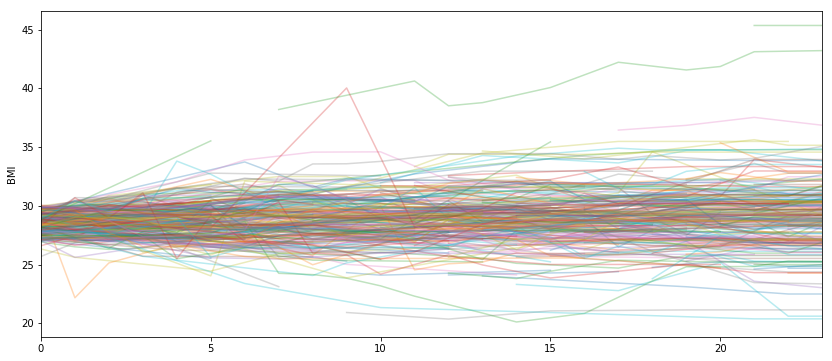

In [41]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.interpolate(limit=5)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [23]:
data_subset.shape

(24, 261)

Stick-breaking function for Dirichlet process

In [24]:
def stick_breaking(beta, complete=False):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    p = beta * portion_remaining
    if not complete:
        return p
    return tt.concatenate([p, [1-p.sum()]])

Maximum number of groups

In [25]:
CLUSTERS = 10
D, N = data_subset.shape

Define knots of spline

In [26]:
KNOTS = 8
knots = np.linspace(0, 24, KNOTS)

In [27]:
X = np.arange(D).reshape(-1, 1)

In [28]:
def interpolate(x0, y0, x):

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [47]:
data_subset.columns = np.arange(data_subset.shape[1])

In [48]:
with Model() as model:
    
    # DP mixture
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=CLUSTERS)
    ω = Deterministic('ω', stick_breaking(β))
    
    # Cluster indices
    z = Categorical('z', ω, shape=N)
    
    # Random walk square-root variance
    σ = HalfCauchy('σ', 5, shape=CLUSTERS)

    θ = tt.stack([GaussianRandomWalk('θ_%i' % i, sd=σ[i], shape=KNOTS) for i in range(CLUSTERS)])

    # Cluster error
    sd = HalfCauchy('sd', 5)
    
    trajectories = [[] for i in range(D-1)]
    
    for i,data in data_subset.iteritems():
        
        observed = ~np.isnan(data)
        y = data[observed].values
        x = np.argwhere(observed)
        n = y.shape[0]
                
        trajectories[n-1].append(Normal('trajectory_%i' % i, 
                                        interpolate(knots, θ[z[i]], x), sd=sd, observed=y))
        
    trajectories = [tt.stack(t) for t in trajectories if t]



In [19]:
with model:
    trace = sample(500, tune=1000)

Assigned NUTS to α_log__
Assigned NUTS to β_logodds__
Assigned CategoricalGibbsMetropolis to z
Assigned NUTS to σ_log__
Assigned NUTS to θ_0
Assigned NUTS to θ_1
Assigned NUTS to θ_2
Assigned NUTS to θ_3
Assigned NUTS to θ_4
Assigned NUTS to θ_5
Assigned NUTS to θ_6
Assigned NUTS to θ_7
Assigned NUTS to θ_8
Assigned NUTS to θ_9
Assigned NUTS to sd_log__
INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
WARNING (theano.gof.compilelock): Refreshing lock failed, we release the lock before raising again the exception


FileNotFoundError: [Errno 2] No such file or directory: '/Users/fonnescj/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock'

In [31]:
from pymc3 import traceplot, forestplot

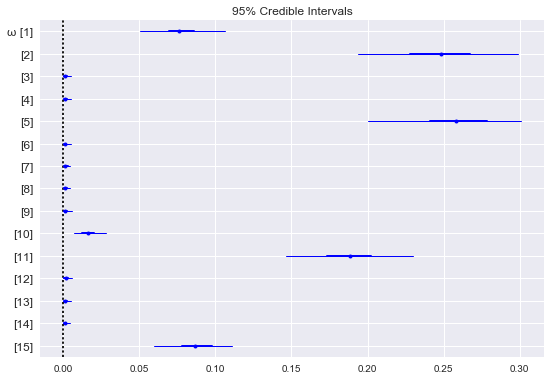

In [32]:
forestplot(trace, varnames=['ω'])

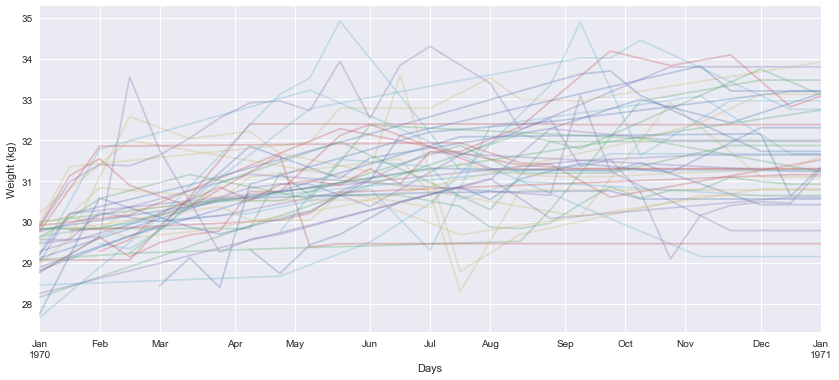

In [33]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==0].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

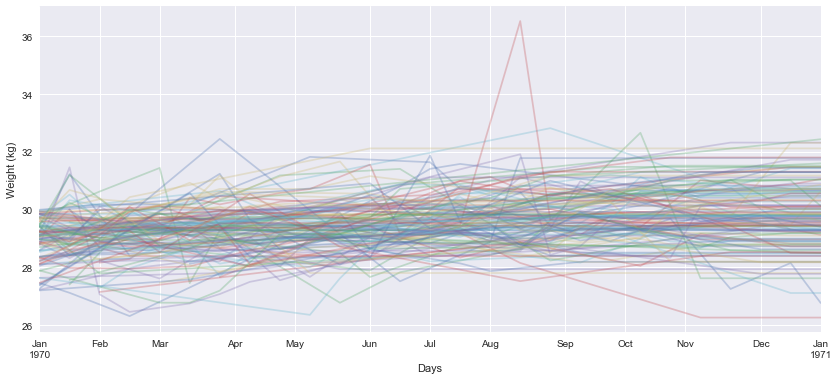

In [34]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==1].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

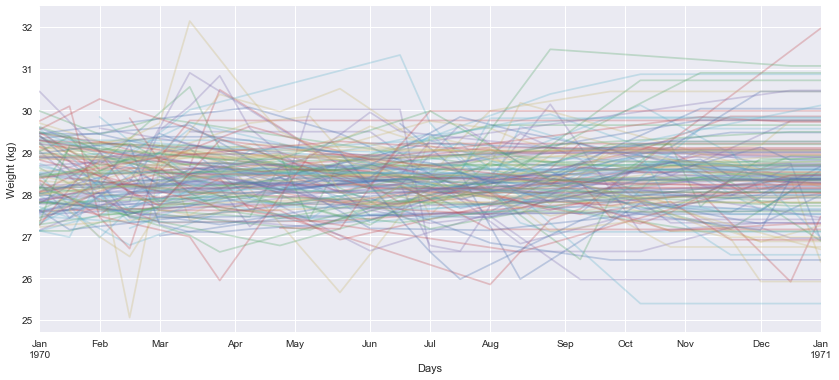

In [35]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==4].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

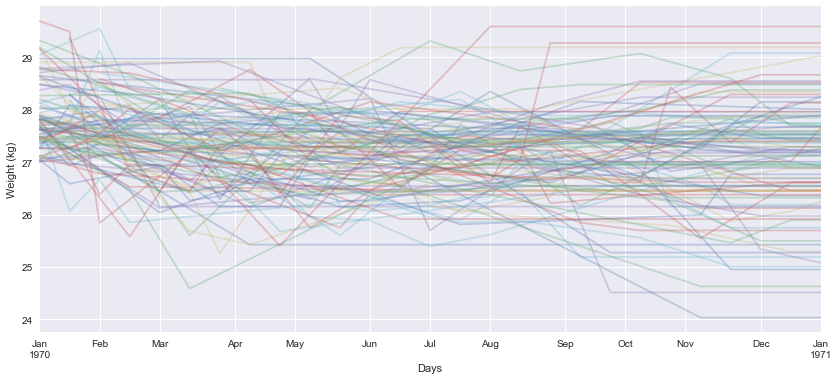

In [36]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==10].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

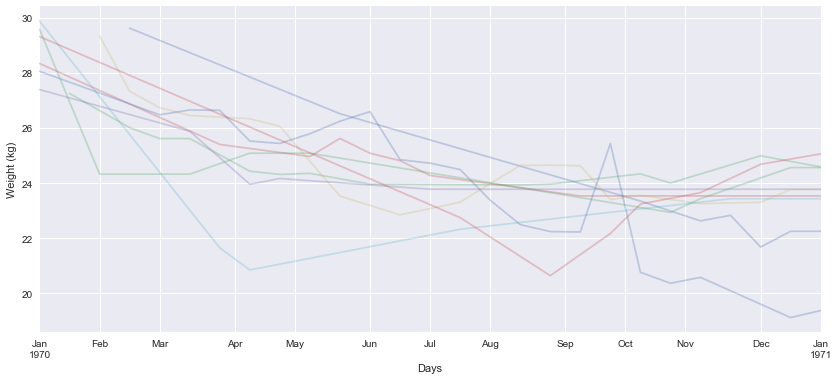

In [37]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==9].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

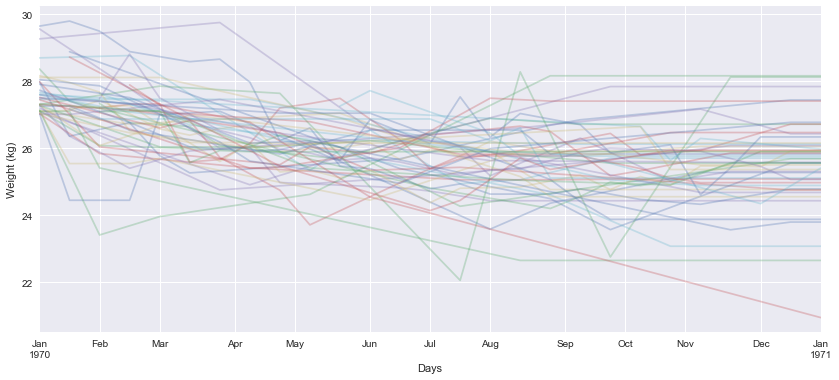

In [38]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==14].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

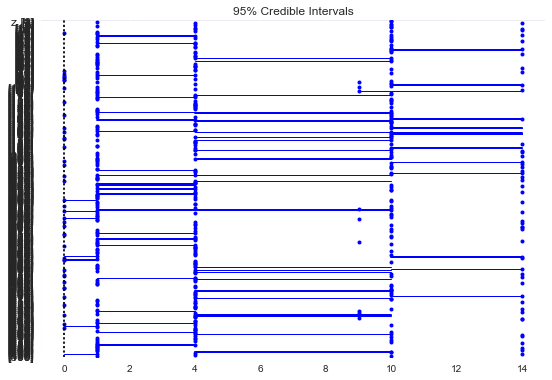

In [39]:
forestplot(trace, varnames=['z'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3993ce668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x398818a20>]], dtype=object)

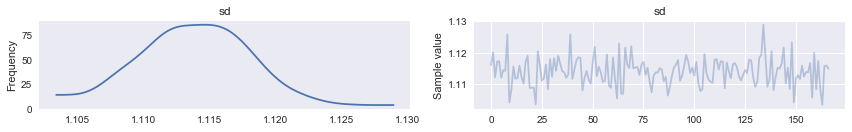

In [40]:
traceplot(trace, varnames=['sd'])